# 1. Download, read and pre-process the data of piezoelectricity

In [ ]:
# download the database
from pymatgen.ext.matproj import MPRester
import shelve

m = MPRester(" ") # the API key of your Materials Project account
data = m.query(criteria={"has" : "piezo"}, properties=["task_id", "pretty_formula", "elements", "structure", "piezo"])
tempShelf = shelve.open('data_materials_piezoelectricity')
tempShelf['data'] = data
tempShelf.close()

In [2]:
import shelve
tempShelf = shelve.open('data_materials_piezoelectricity')
data = tempShelf['data']
tempShelf.close()

In [3]:
import pandas as pd
import numpy as np
import pymatgen.core as mg
import deepchem as dc

df = pd.DataFrame(data)
df = df.dropna(axis=0, how='any')
df.head()
#df.to_hdf('data_materials_piezoelectricity.h5',key='df', mode='w')

,task_id,pretty_formula,elements,structure,piezo
0,mp-1025377,Cd(AgI2)2,"[Cd, Ag, I]","[[0. 0. 0.] Cd, [0. 3.290139 3.2405505...","{'eij_max': 0.4449199999999998, 'piezoelectric..."
1,mp-11714,SiC,"[Si, C]","[[ 1.547003 -0.89316445 9.49836211] Si, [1....","{'eij_max': 0.06423169544702993, 'piezoelectri..."
2,mp-16804,LiCaPO4,"[Ca, Li, O, P]","[[1.06408709 1.31259638 2.5765186 ] Li, [5.998...","{'eij_max': 0.7665100785536847, 'piezoelectric..."
3,mp-17771,NaMg4(AsO4)3,"[As, Mg, Na, O]","[[3.453018 0. 4.876712] Na, [0. 0....","{'eij_max': 0.170635, 'piezoelectric_tensor': ..."
4,mp-22995,Ag3SI,"[Ag, I, S]","[[ 1.94462322 -1.74755883 1.89344403] Ag, [1....","{'eij_max': 0.31288833563086854, 'piezoelectri..."


In [4]:
df_piezo = df['piezo'].apply(pd.Series)
df_piezo['piezoelectric_tensor'][0]
df_full = pd.concat([df[['task_id', 'pretty_formula', 'elements', 'structure']], 
                     df_piezo['piezoelectric_tensor'].apply(np.array)], axis=1)
df_full_clean = df_full.dropna(axis=0, how='any')

piezo_series_flatten = df_full_clean['piezoelectric_tensor'].apply(np.ravel)
piezo_arr = np.array(piezo_series_flatten.to_list())


(3399, 18)

# 2 Models to predicit elastic tensor from composition

## 2.1 generate the dataset

### 2.1.1 featurizer ElementPropertyFingerprint(EPF)

In [78]:
comps = df_full_clean['pretty_formula'].to_list()
featurizer_comps = dc.feat.ElementPropertyFingerprint()
features_comps = featurizer_comps.featurize(comps)
dataset_comps_EPF = dc.data.NumpyDataset(X=features_comps, y=piezo_arr, ids=np.array(comps))
dataset_comps_EPF.to_dataframe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,y11,y12,y13,y14,y15,y16,y17,y18,w,ids
0,1.69,2.66,0.97,2.312857,0.539246,5.0,5.0,0.0,5.000000,0.000000,...,-0.361625,0.000000,0.000000,0.00000,0.00000,0.0,0.0,-0.444920,1.0,Cd(AgI2)2
1,1.90,2.55,0.65,2.225000,0.459619,2.0,3.0,1.0,2.500000,0.707107,...,0.000000,0.000000,0.010970,0.01097,-0.06233,0.0,0.0,0.000000,1.0,SiC
2,0.98,3.44,2.46,2.561429,1.380234,2.0,4.0,2.0,2.428571,0.930949,...,0.000000,-0.522497,0.249300,0.24930,0.07359,0.0,0.0,0.000000,1.0,LiCaPO4
3,0.93,3.44,2.51,2.699500,1.259527,2.0,4.0,2.0,2.550000,0.975794,...,0.170635,0.000000,0.000000,0.00000,0.00000,0.0,0.0,0.115970,1.0,NaMg4(AsO4)3
4,1.93,2.66,0.73,2.206000,0.452974,3.0,5.0,2.0,4.600000,1.069045,...,0.206390,-0.131457,0.128940,0.12894,0.10721,0.0,0.0,0.000000,1.0,Ag3SI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394,1.54,3.44,1.90,2.806667,1.343503,2.0,4.0,2.0,2.666667,1.414214,...,0.000000,0.000000,-0.358350,-0.35835,-0.44154,0.0,0.0,0.000000,1.0,TiO2
3395,2.36,3.44,1.08,3.170000,0.763675,2.0,6.0,4.0,3.000000,2.828427,...,0.217650,0.000000,0.000000,0.00000,0.00000,0.0,0.0,-0.001702,1.0,WO3
3396,1.31,3.44,2.13,2.894444,1.134700,2.0,5.0,3.0,2.777778,1.746425,...,0.000000,0.000000,1.645067,-0.62054,-0.64020,0.0,0.0,0.000000,1.0,Mg(SbO3)2
3397,1.65,3.44,1.79,2.745833,1.096159,2.0,5.0,3.0,3.000000,1.623005,...,0.000000,0.000000,0.120770,0.33928,-0.38466,0.0,0.0,0.000000,1.0,Zn3Sn2O7


In [67]:
splitter = dc.splits.RandomSplitter()
train_comps, valid_comps, test_comps = splitter.train_valid_test_split(dataset_comps_EPF, 
                                                                       frac_train=0.8, 
                                                                       frac_valid=0.1, 
                                                                       frac_test=0.1)

### 2.1.2 featurizer ElementNetFeaturizer(ENF)

In [145]:
featurizer_comps = dc.feat.ElemNetFeaturizer()
features_comps = featurizer_comps.featurize(comps)
features_comps.shape
np.isnan(features_comps).any()
dataset_comps_ENF = dc.data.NumpyDataset(X=features_comps, y=piezo_arr, ids=np.array(comps))
dataset_comps_ENF.to_dataframe()['y10'].describe()

count    3399.000000
mean        0.017753
std         0.778102
min        -8.409550
25%         0.000000
50%         0.000000
75%         0.000000
max        28.786016
Name: y10, dtype: float64

In [169]:
# transform and split dataset
transformer = dc.trans.NormalizationTransformer(transform_y=True,dataset = dataset_comps_ENF)
#transformer = dc.trans.MinMaxTransformer(transform_y=True, dataset = dataset_comps_ENF)
dataset_comps_ENF = transformer.transform(dataset_comps_ENF)
splitter = dc.splits.RandomSplitter()
train_comps, valid_comps, test_comps = splitter.train_valid_test_split(dataset_comps_ENF, 
                                                                       frac_train=0.6, 
                                                                       frac_valid=0.3, 
                                                                       frac_test=0.1)

## 2.2 build and train the model

In [170]:
import torch
import matplotlib.pyplot as plt

pytorch_model = torch.nn.Sequential(   #ENF:86 EPF:65
    torch.nn.Linear(86, 86),
    #torch.nn.Tanh(),
    torch.nn.LeakyReLU(0.1),
    #torch.nn.Dropout(0.5),
    torch.nn.Linear(86, 60),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(60, 40),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(40, 18),  
)

model = dc.models.TorchModel(pytorch_model, dc.models.losses.L2Loss(),batch_size=64,learning_rate=0.001)
metric = dc.metrics.Metric(dc.metrics.r2_score)

In [171]:
for i in range(10):
    model.fit(train_comps, nb_epoch=50)
    #train_r2.append(model.evaluate(train_struct, [metric],[transformer])[r2_score])
    #valid_r2.append(model.evaluate(valid_struct, [metric],[transformer])['r2_score'])
    #test_r2.append(model.evaluate(test_struct, [metric],[transformer])['r2_score'])
    
    print('train set score:', model.evaluate(train_comps, [metric],[transformer]))
    print('valid set score:', model.evaluate(valid_comps, [metric], [transformer]))
    print('test set score:', model.evaluate(test_comps, [metric], [transformer]))

train set score: {'r2_score': 0.17616180608796878}
valid set score: {'r2_score': -0.6020368285046187}
test set score: {'r2_score': -0.5095725130228416}
train set score: {'r2_score': 0.41321165481958466}
valid set score: {'r2_score': -0.9270513810733492}
test set score: {'r2_score': -0.922836919201149}
train set score: {'r2_score': 0.4912018467376893}
valid set score: {'r2_score': -1.0937315505057568}
test set score: {'r2_score': -1.25141794045435}
train set score: {'r2_score': 0.5639666768836293}
valid set score: {'r2_score': -1.0895033370606855}
test set score: {'r2_score': -0.9848016878450196}
train set score: {'r2_score': 0.6324597175257236}
valid set score: {'r2_score': -1.2895156191222585}
test set score: {'r2_score': -1.1050344132513796}
train set score: {'r2_score': 0.6753134290897829}
valid set score: {'r2_score': -1.217732418570102}
test set score: {'r2_score': -1.0163524449997943}
train set score: {'r2_score': 0.6972819038763721}
valid set score: {'r2_score': -1.3575916771241

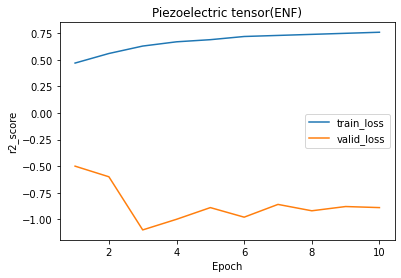

In [172]:
# plot the r2_score-Epoch
train_r2 = [0.47,0.56,0.63,0.67,0.69,0.72,0.73,0.74,0.75,0.76]
valid_r2 = [-0.5,-0.6,-1.1,-1,-0.89,-0.98,-0.86,-0.92,-0.88,-0.89]
test_r2 = []

epoch_list = np.linspace(1,10,10)
plt.plot(epoch_list, 
         train_r2, 
         '-', 
         label = 'train_loss')
plt.plot(epoch_list, 
         valid_r2, 
         '-', 
         label = 'valid_loss')
plt.xlabel('Epoch')
plt.ylabel('r2_score')
plt.title('Piezoelectric tensor(ENF)')
plt.legend()
plt.savefig('ENF2.jpg')

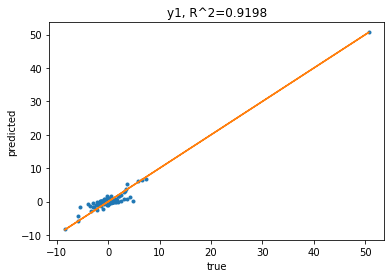

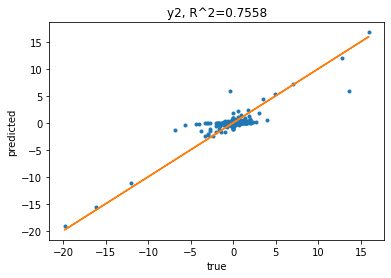

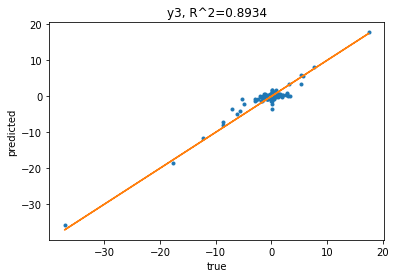

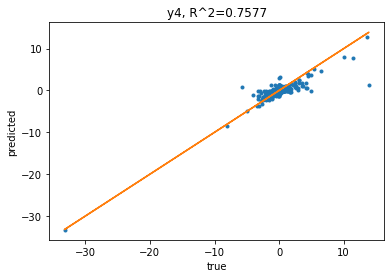

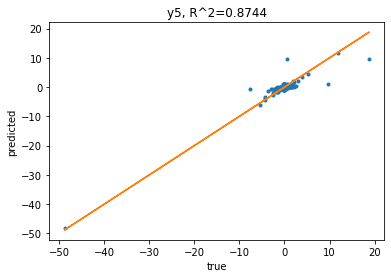

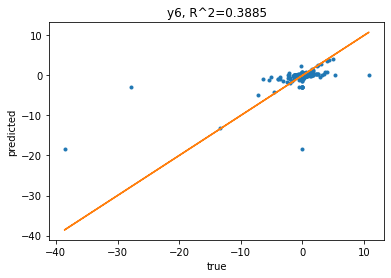

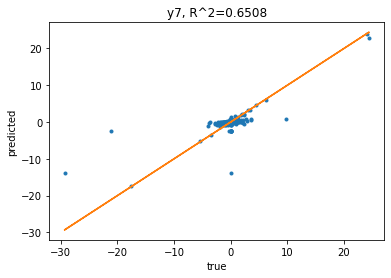

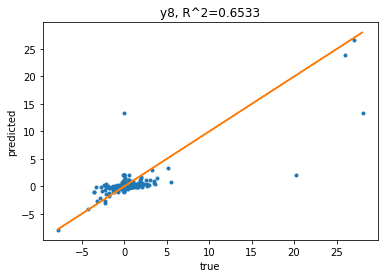

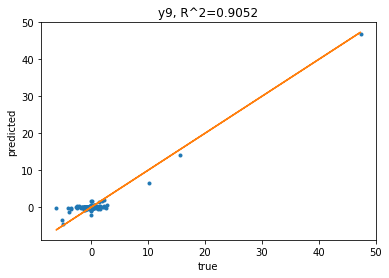

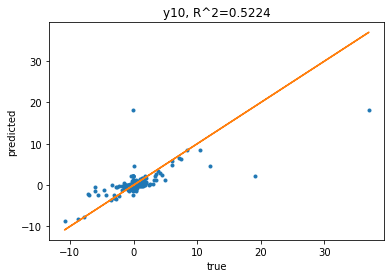

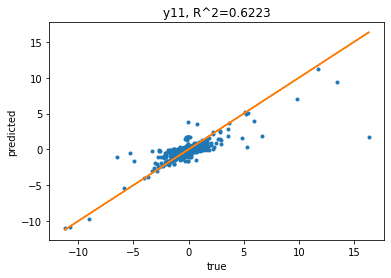

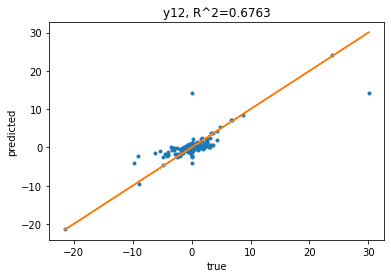

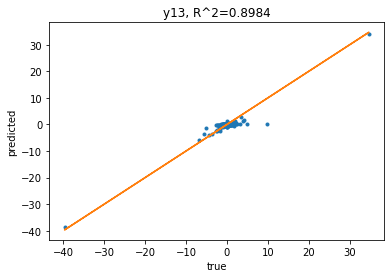

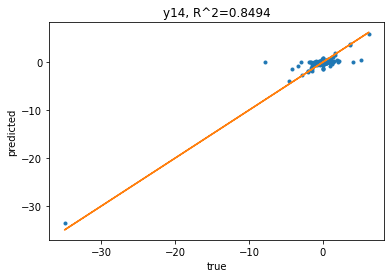

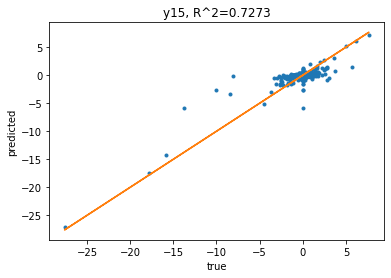

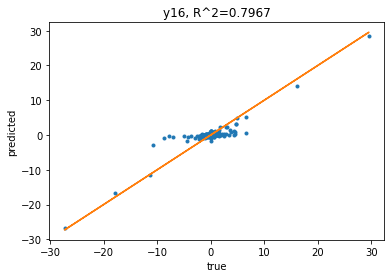

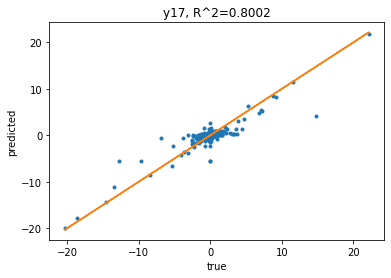

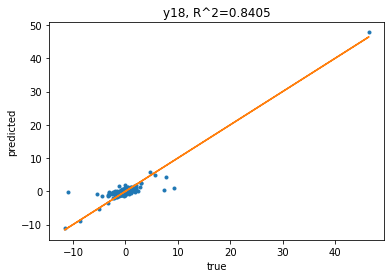

In [161]:
import matplotlib.pyplot as plt

Y_true=train_comps.y
Y_pred=model.predict(train_comps)

for i in range(18):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'y{i+1}, R^2={R_2:.4f}')
    plt.savefig(f'results/Piezo_ENF/y{i+1}')
    plt.show()

In [73]:
import torch

X_train = torch.Tensor(train_comps.X)
Y_train = torch.Tensor(train_comps.y)
X_valid = torch.Tensor(valid_comps.X)
Y_valid = torch.Tensor(valid_comps.y)
X_test = torch.Tensor(test_comps.X)
Y_test = torch.Tensor(test_comps.y)

dataset_train_tensor = torch.utils.data.TensorDataset(X_train, Y_train)
dataset_valid_tensor = torch.utils.data.TensorDataset(X_valid, Y_valid)
dataset_test_tensor = torch.utils.data.TensorDataset(X_test, Y_test)

trainloader = torch.utils.data.DataLoader(dataset_train_tensor, batch_size=100, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset_valid_tensor, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test_tensor, shuffle=True)


In [74]:
# build a Pytorch NN
m = torch.nn.Sequential(torch.nn.Linear(65, 65),  #EPF input 65, ENF input 86    
                  torch.nn.Tanh(), 
                  torch.nn.Linear(65, 41),   
                  torch.nn.Tanh(),
                  torch.nn.Linear(41, 25),
                  torch.nn.LeakyReLU(0.1),
                  torch.nn.Linear(25, 18))  
m.float()

Sequential(
  (0): Linear(in_features=65, out_features=65, bias=True)
  (1): Tanh()
  (2): Linear(in_features=65, out_features=41, bias=True)
  (3): Tanh()
  (4): Linear(in_features=41, out_features=25, bias=True)
  (5): LeakyReLU(negative_slope=0.1)
  (6): Linear(in_features=25, out_features=18, bias=True)
)

In [146]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters())
num_epochs = 5000

for i in range(num_epochs):
    cum_loss = 0

    for x, y in trainloader:
        optimizer.zero_grad()
        y_pred = m(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
    if i % 100 == 0:
        print(f"epoch: {i}, Training loss: {cum_loss/len(trainloader)}")

In [76]:
cum_loss = 0
for x, y in testloader:
    y_pred = m(x)
    loss = criterion(y_pred, y)
    cum_loss += loss.item()
print(f"test loss: {cum_loss/len(testloader)}")

test loss: 0.16941083197371506


In [127]:
#plot each of 18 properties


with torch.no_grad():
    Y_pred = m(X_test).numpy()
Y_true = Y_test.numpy()

for i in range(18):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'Y{i+1}, R^2={R_2:.4f}')
    #plt.savefig(f'results/Piezo_EPF/Y{i+1}')
    plt.show()

# 3. Models to predicit elastic tensor from structure and composition(CGCNN)

## 3.1 generate the dataset

In [176]:
featurizer_struct = dc.feat.CGCNNFeaturizer()
struct = df_full_clean['structure'].to_list()
features_struct = featurizer_struct.featurize(struct)
dataset_struct_CG = dc.data.NumpyDataset(X=features_struct, y=piezo_arr, ids=np.array(comps))

In [177]:
# transform and split the dataset
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset = dataset_struct_CG)
#transformer = dc.trans.MinMaxTransformer(transform_y=True, dataset = dataset_struct_CG)
dataset_struct_CG = transformer.transform(dataset_struct_CG)

splitter = dc.splits.RandomSplitter()
train_struct, valid_struct, test_struct = splitter.train_valid_test_split(dataset_struct_CG, 
                                                                          frac_train=0.8,
                                                                          frac_valid=0.1,
                                                                          frac_test=0.1)

## 3.2 build and train the model

In [179]:
# build the model
model = dc.models.CGCNNModel(mode='regression',n_tasks=18, batch_size=64, learning_rate=0.001)
metric = dc.metrics.Metric(dc.metrics.r2_score)

train_r2 = []
valid_r2 = []

# train the model
for i in range(10):
    model.fit(train_struct, nb_epoch=1)
    
#evaluate the model
    train_r2.append(model.evaluate(train_struct, [metric])['r2_score'])
    valid_r2.append(model.evaluate(valid_struct, [metric])['r2_score'])
    
    print("Training set score:", model.evaluate(train_struct, [metric], [transformer], per_task_metrics = True))
    print("Valid set score:", model.evaluate(valid_struct, [metric], [transformer]))
    print("Test set score:", model.evaluate(test_struct, [metric], [transformer]))

Training set score: ({'r2_score': -0.0514653355409279}, {'r2_score': [-0.002031859729840324, -0.01168651704180168, -0.0043648355522807325, -0.02023658745092205, -0.0812493601562374, -0.2948476478849871, -0.025263097007322877, -0.0472902238268369, -0.058555798906741785, -0.01741876032324119, -0.03730173575545481, -0.04558101549713722, -0.04339568409376682, -0.00799566058550738, -0.00828993758775498, -0.030449876048948887, -0.025551443583958777, -0.16486599870396135]})
Valid set score: {'r2_score': -0.26980444879580073}
Test set score: {'r2_score': -0.15770422277361323}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': -0.012700641629381861}, {'r2_score': [-0.005994105277039585, -0.009747806213086463, 0.011226032756538884, -0.028671224384893446, -0.006200293901862164, -0.03279619528333888, -0.00478346278909636, -0.0014827906303100935, -0.009258036979578499, -0.021915426901975232, -0.0036622088140956244, -0.05841637253307219, -0.01217351267168576, 0.013422442829909786, -0.028637819342157256, -0.02924403376372009, -0.006753790813421201, 0.006477055384010666]})
Valid set score: {'r2_score': -0.10722098993618198}
Test set score: {'r2_score': -0.13192534829013655}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': -0.013459626291029191}, {'r2_score': [0.003106280169118514, -0.10989518799778386, 0.020154817761405486, 0.008146152361061532, 0.0019838809471333096, -0.033049726572159654, 0.0013867337689799086, -0.10870202342479507, -0.035441254656580545, -0.007822147461425732, -0.006125870208546047, 0.009127674792608342, -0.00363003657592631, -0.002905798466317888, 0.011871280174989063, 0.00108216829687946, -0.005368485578344462, 0.013808269431178521]})
Valid set score: {'r2_score': -0.17566953829877227}
Test set score: {'r2_score': -0.13557447366391434}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': -0.024333280733446865}, {'r2_score': [-0.021518020328832987, -0.01992711880504916, -0.08447160294689349, 0.007139784627002599, 0.010300729955073584, -0.0230865194962111, -0.01266759744380419, -0.06906878481931389, 0.002913877245524832, -0.022930389963316644, 0.01025911086704312, -2.6189995037784186e-05, 0.004693742659269806, 0.02124517585326202, 0.018714806655276583, -0.21806301002339357, -0.006248628727534067, -0.03525841851510925]})
Valid set score: {'r2_score': -0.1680243382629239}
Test set score: {'r2_score': -0.2983749866989014}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': 0.012718123826302009}, {'r2_score': [0.011176483990692265, 0.011885087981055364, 0.03620422828926362, 0.014914514665632539, 0.0044694703062838625, 0.007099025924209856, 0.01593697983006559, 0.0009347354335952351, -0.00014161012547697638, 0.007145347933175894, 0.005250968196616523, 0.017101329191492876, 0.021854688375800402, 0.02758340053530961, 0.02769876391131043, 0.006196793859334693, 0.013156749343865348, 0.00045927123120903524]})
Valid set score: {'r2_score': -0.08526117605838049}
Test set score: {'r2_score': -0.08320445454285691}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': 0.005566743476376892}, {'r2_score': [0.019028419817289977, 0.012044591313294495, -0.06353259958061686, 0.025136573818135943, -0.0028302183084658594, -0.03346507008483779, 0.031103643699922356, 0.015489461389759485, 0.005237295850056722, -0.009851092147828533, 0.004090098709512158, 0.029032229652633523, 0.03230113496865128, 0.015760520983755022, 0.00016454601452386974, 0.01798681863045115, 0.008652913886326608, -0.006147886037779493]})
Valid set score: {'r2_score': -0.15736393918632874}
Test set score: {'r2_score': -0.18453751964302537}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': 0.0006049634920449928}, {'r2_score': [0.012407904348242682, -0.015056302977247249, 0.02318927095013823, 0.03071487461733169, 0.0076042919166280365, -0.05908611875017189, -0.02583689757031471, 0.008904468192470039, 0.006921834829069495, -0.0769889241133872, 0.021130415087824872, 0.03435766804025775, 0.018475965842837394, 0.027424049054787014, 0.019768688460003125, -0.08454592699553376, 0.04094970509853091, 0.020554376825343446]})
Valid set score: {'r2_score': -0.19167756261628577}
Test set score: {'r2_score': -0.21735956777231868}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': 0.018196654430626576}, {'r2_score': [0.04606066260567443, 0.005830039631553818, 0.07181402990191998, 0.018190495796960304, -0.0073320445242632815, 0.006740464278355285, 0.04192975388036524, 0.025150601245396143, -0.0074148786342722595, 0.045890374115968746, 0.02511650124529119, -0.09806226902232607, 0.046958426230292116, 0.03395249964560498, 0.03504528561904585, -0.018243641583180814, 0.05048512093529178, 0.005428358383600895]})
Valid set score: {'r2_score': -0.12388461643465071}
Test set score: {'r2_score': -0.13765240658005962}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': 0.025738980893144}, {'r2_score': [0.08734214089575199, 0.016229144027364528, 0.029832556715848724, 0.052685739854265945, 0.012372630961026254, -0.026399673348151076, 0.0702750731459586, 0.04589168947691302, -0.13451198910792983, -2.972628086328477e-05, 0.009457925895864139, 0.05387325991550418, 0.06993059248422917, 0.04335612807062328, 0.04419993503922193, 0.03556498696497057, 0.05703464850570272, -0.0038034071397088365]})
Valid set score: {'r2_score': -0.29377473787129227}
Test set score: {'r2_score': -0.3159000748613803}


/Users/fuyulei/opt/anaconda3/envs/DeepChem/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training set score: ({'r2_score': -0.01958459732362082}, {'r2_score': [-0.367371296231507, -0.059157430891428664, 0.03174684474954592, 0.050106889363776386, 0.03150769680518184, -0.033119100817728064, 0.0384748664227379, 0.04205186948749906, 0.008463793797422792, -0.15474227822513575, -0.028339003630780013, 0.06828365874391507, 0.010182299494910119, -0.06438558005134354, -0.04212530589228747, 0.01189136186360229, 0.0635218190278678, 0.04048614415857654]})
Valid set score: {'r2_score': -0.4080960202177103}
Test set score: {'r2_score': -0.5712689399904253}


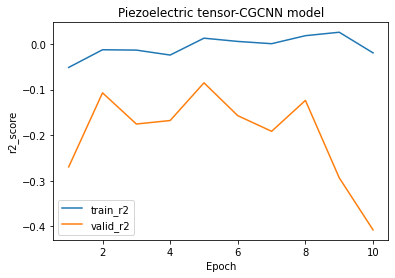

In [181]:
# plot loss-Epoch
epoch_list = np.linspace(1,10,10)
plt.plot(epoch_list, 
         train_r2, 
         '-', 
         label = 'train_r2')
plt.plot(epoch_list, 
         valid_r2, 
         '-', 
         label = 'valid_r2')
plt.xlabel('Epoch')
plt.ylabel('r2_score')
plt.title('Piezoelectric tensor-CGCNN model')
plt.legend()
plt.savefig('CGCNN_piezo.jpg')

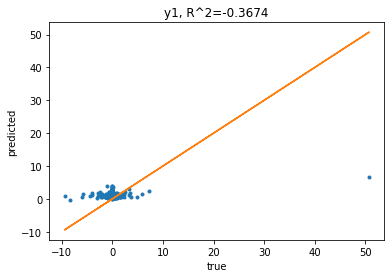

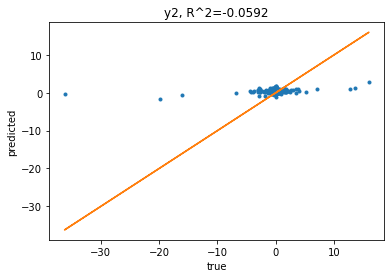

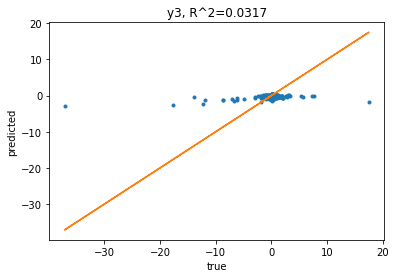

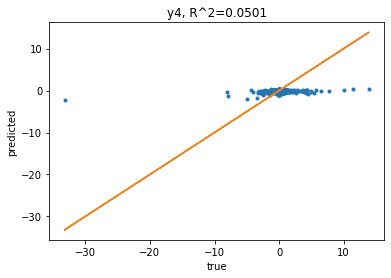

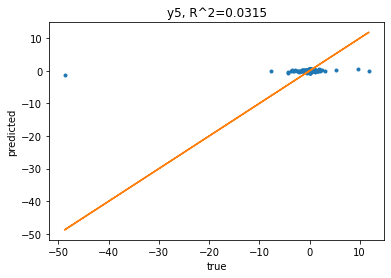

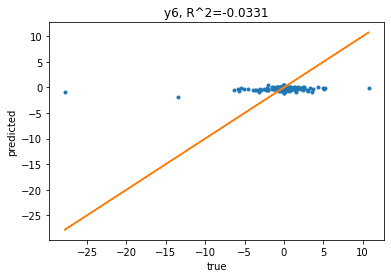

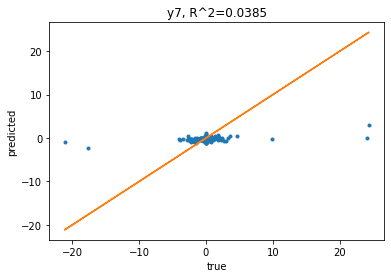

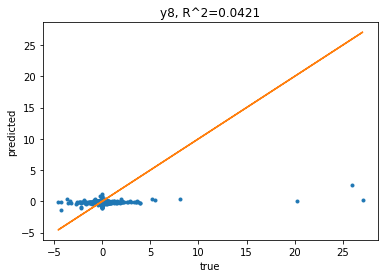

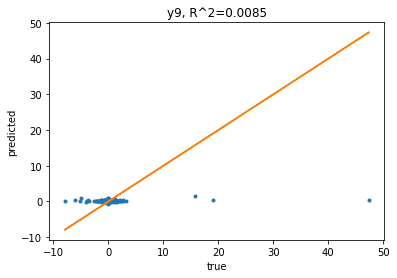

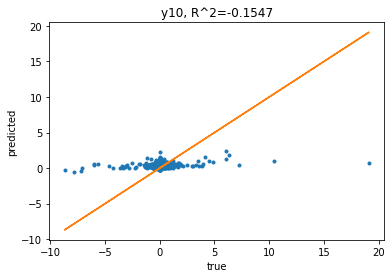

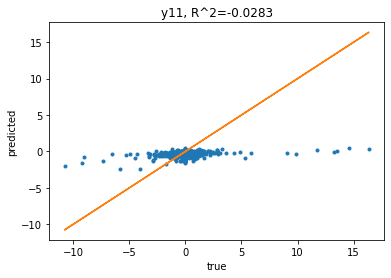

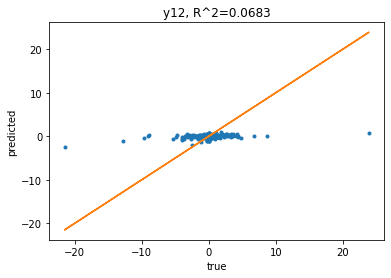

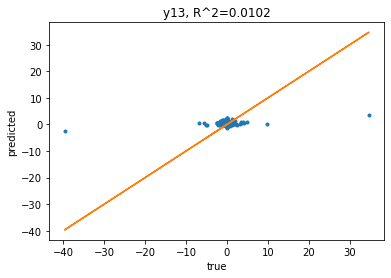

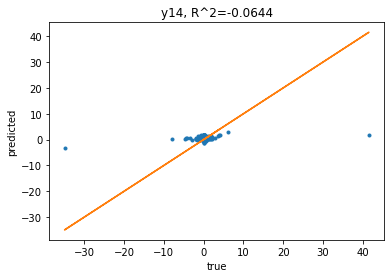

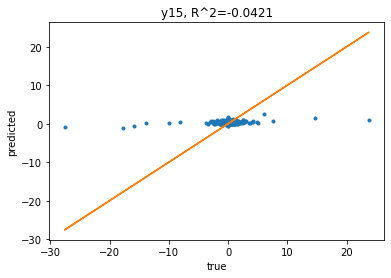

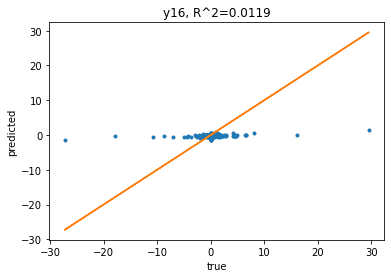

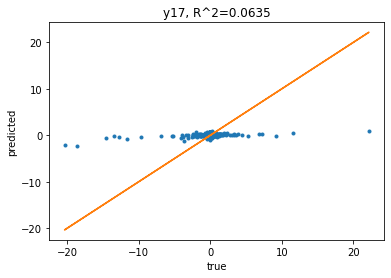

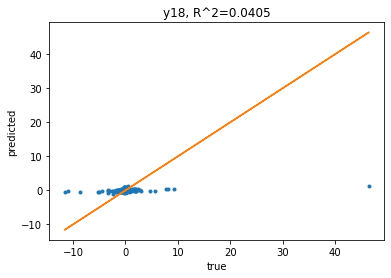

In [183]:
# plot the 18 independent variable of piezoelectric tensor
Y_true = train_struct.y
Y_pred = model.predict(train_struct)

for i in range(18):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1-np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'y{i+1}, R^2={R_2:.4f}')
    plt.savefig(f'results/Piezo_CGCNN/y{i+1}')
    plt.show()